
Given 
$\Phi_1=
\begin{bmatrix} 0.5 & 0.1 \\ 0.4 & 0.5 \end{bmatrix}
$
$\alpha=\begin{bmatrix} 1 \\ -1 \end{bmatrix}$
and $\gamma_1=\begin{bmatrix} 0 \\ 0.3 \end{bmatrix}$
$\gamma_2=\begin{bmatrix} 0 \\ 0.03 \end{bmatrix}$
$\gamma_3=\begin{bmatrix} -0.25 \\ 0.1 \end{bmatrix}$
$\gamma_4=\begin{bmatrix} 0 \\ 0 \end{bmatrix}$

The simulations are generated using the VECM(1) process with the given parameters for T_1=250, T_2=2500

The processes for $\gamma_1,\gamma_2,\gamma_3$ are cointegrated, the following properties hold for VECM, VAR, VAR$(\Delta X)$ 

VECM <br>
1) Co-integrated and I(1) processes- VECM is consistent and efficient- expected for $\gamma_1,\gamma_2,\gamma_3$<br>
2) No Co-integration and I(1) processes- VECM is mis-specified- expected for $\gamma_4$

VAR <br>
1) Co-integrated and I(1) processes- VAR is consistent but not efficient- expected for $\gamma_1,\gamma_2,\gamma_3$<br>
2) No Co-integration and I(1) processes- VAR is consistent but not efficient- expected for $\gamma_4$

VAR$(\Delta X)$ <br>
1) Co-integrated and I(1) processes- VAR$(\Delta X)$ is mis-specified and is inconsistent- expected for $\gamma_1,\gamma_2,\gamma_3$<br>
2) No Co-integration and I(1) processes- VAR$(\Delta X)$  is consistent and efficient- expected for $\gamma_4$


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math
import statsmodels.api as sm

mean=0
sigma=1


In [60]:
def ols(y,x,w):                                                  #w=0 for homoskedasticity
#     print(y)
#     print(x)
    y=y.astype(float)
    x=x.astype(float)


    Beta= np.dot(np.dot(inv(np.dot(x.T,x)),x.T),y)       #Beta estimator
    e=y-np.dot(x,Beta)                                         #error term
    s2=(1/len(y.index))*np.dot(e.T,e)                          #sigma^2 term for homoskedasticity case
    
    P=np.dot(x,np.dot(inv(np.dot(x.T,x)),x.T))           #P matrix
    M=np.identity(P.shape[0])-P                                   #M matrix
    
    if w==0:
        V=s2*inv(np.dot(x.T,x))                                #homoskedastic case
    else:
        
        D=np.diag(np.diag(np.dot(np.matrix(e),np.matrix(e.T))))  #diagonal matrix for white estimator        
        xdx= np.dot(np.dot(x.T,D),x)        
        V=np.dot(np.dot(inv(np.dot(x.T,x)),xdx),inv(np.dot(x.T,x)))   #heteroskedasticity-robust White estimator
        
    se=np.diag(V)**0.5                                                            #standard error calculation
    max_loglikeli= (-len(x.index)/2)*(math.log(2*math.pi)+1+math.log(s2))      #optimal loglikelihood value- natural log
    ymean=np.mean(y)
    R2=1-(np.dot(e.T,e)/np.dot((y-ymean).T,(y-ymean)))                      #Coeff of determination
    
    return Beta,se,max_loglikeli,R2,e

In [61]:
def PACF(y,lags):
    
    pacf=np.zeros((1,lags))
    df_x=y[lags:len(y.index)-1].copy()
   
    for i in range(1,lags):
        df_x["x"+str(i)]=y[lags-i:len(y.index)-i-1].values

    df_y=y[lags+1:]
    df_y=df_y.reset_index(drop=True)
    df_x=df_x.reset_index(drop=True)        

    ones=np.ones((len(df_x.index),1))                         
    df_ones=pd.DataFrame(ones)
    df_x["x0"]=df_ones
    


    [Beta,se,max_loglikeli,R2,e]=ols(df_y,df_x,0)
    pacf=Beta[lags-1]
    
    return pacf

## Simulations

In [62]:
def simulate_process(gamma, T):
    gamma_1= gamma[0]
    gamma_2=gamma[1]
    phi_11=0.2
    phi_12=-0.1
    phi_21=0
    phi_22=-0.25
    
    
    x1=np.zeros((1,T))
    x2=np.zeros((1,T))
    
    W1=np.random.normal(mean, sigma, T)
    W2=np.random.normal(mean, sigma, T)
    
    delta_1=np.zeros((1,T))
    delta_2=np.zeros((1,T))

    for i in range (1,T):

        delta_1[0][i]=gamma_1*(x1[0][i-1]-x2[0][i-1])+phi_11*delta_1[0][i-1]+phi_12*delta_2[0][i-1]+W1[i-1]
        delta_2[0][i]=gamma_2*(x1[0][i-1]-x2[0][i-1])+phi_21*delta_1[0][i-1]+phi_22*delta_2[0][i-1]+W2[i-1]

        x1[0][i]=x1[0][i-1]+delta_1[0][i]
        x2[0][i]=x2[0][i-1]+delta_2[0][i]
    
    return x1[0],x2[0]


In [63]:
def plot_ACF(x, p):
    x = np.array(x).reshape((-1,1))
    T = x.shape[0]
    se_approx = 1 / np.sqrt(T)
    ACF = np.zeros(p)
    ACF[0] = 1
    for i in range(1, p):
        ACF[i] = np.dot(x[i:, 0].T - np.average(x[i:, 0]), x[:-i, 0] - np.average(x[:-i, 0])) \
                 / np.dot(x.T - np.average(x), x - np.average(x))
    plt.stem(ACF)
    plt.fill_between(x=range(p+1), y1=-1.96 * se_approx, y2=1.96 * se_approx, facecolor='blue', alpha=0.1)

In [64]:
def solve_Vecm1(x1,x2):
    delta_x1=  np.zeros((1,len(x1)-1))
    delta_x2=  np.zeros((1,len(x2)-1))
    z_t= x1-x2                                          #rows=T

    for i in range(1,len(x1)):
        delta_x1[0][i-1]=x1[i]-x1[i-1]
        delta_x2[0][i-1]=x2[i]-x2[i-1]                      #rows=T-1


    # For eqn 1 --x1
    Y=pd.DataFrame(delta_x1[0][1:])
    X=pd.DataFrame(z_t[1:-1])
    X.columns=["Z_t-1"]
    X["del_x1"]=pd.DataFrame(delta_x1[0][:-1])
    X["del_x2"]=pd.DataFrame(delta_x2[0][:-1])
    ones=np.ones((len(X.index),1))                         
    df_ones=pd.DataFrame(ones)
    X["const"]=df_ones
    model = sm.OLS(Y, X)
    results_x1 = model.fit()

    # For eqn 2 --x2    
    Y=pd.DataFrame(delta_x2[0][1:])
    X=pd.DataFrame(z_t[1:-1])
    X.columns=["Z_t-1"]
    X["del_x1"]=pd.DataFrame(delta_x1[0][:-1])
    X["del_x2"]=pd.DataFrame(delta_x2[0][:-1])
    ones=np.ones((len(X.index),1))                         
    df_ones=pd.DataFrame(ones)
    X["const"]=df_ones
    model = sm.OLS(Y, X)
    results_x2 = model.fit()
    
    return results_x1,results_x2



In [65]:
def Var(x1,x2,lags):

    length=len(x1)
    Y=pd.DataFrame(x1[lags:])
    Y.columns=["x1"]
    Y["x2"]=pd.DataFrame(x2[lags:])

    ones=np.ones((len(Y.index),1))                         
    X=pd.DataFrame(ones)
    X.head()

    p=lags
    i=0
    while (p>0):
        X["x1_lags p="+str(p)]=pd.DataFrame(x1[p-1:length-1-i])
        p=p-1
        i=i+1
    j=0  
    p=lags
    while (p>0):
        X["x2_lags p="+str(p)]=pd.DataFrame(x2[p-1:length-1-j])
        p=p-1
        j=j+1

    
    model = sm.OLS(Y, X)
    results = model.fit()

    return results

In [66]:
def longrun_regress(x1,x2,lags):    
    k=lags
    z=x1-x2
    X=pd.DataFrame(z[:-k])
    X.columns=["Z_t"]

    ones=np.ones((len(X),1))                         
    X['const']=pd.DataFrame(ones)

    delta_x1=  np.zeros((1,len(x1)-1))
    delta_x2=  np.zeros((1,len(x2)-1))

    for i in range(1,len(x1)):
        delta_x1[0][i-1]=x1[i]-x1[i-1]
        delta_x2[0][i-1]=x2[i]-x2[i-1] 
        
    if k==1:    
        Y1=delta_x1[0][0:]
    else:
        Y1=delta_x1[0][0:-k+1]
        if k>2:   
            for i in range(1,k-1):
                Y1=Y1+ delta_x1[0][i:-k+i+1]
        Y1=Y1+delta_x1[0][k-1:]
    
    Y1=pd.DataFrame(Y1)
    Y1.columns=["x1"]
    model1 = sm.OLS(Y1, X)
    results1 = model1.fit()

    

    if k==1:    
        Y2=delta_x2[0][0:]
    else:
        Y2=delta_x2[0][0:-k+1]
        if k>2:   
            for i in range(1,k-1):
                Y2=Y2+ delta_x2[0][i:-k+i+1]
        Y2=Y2+delta_x2[0][k-1:]
    
    Y2=pd.DataFrame(Y2)
    Y2.columns=["x2"]
    model2 = sm.OLS(Y2, X)
    results2 = model2.fit()
    
    [Beta_tocheck,se,max_loglikeli,R2,e_x1]=ols(Y1,X,1)
    [Beta_tocheck,se,max_loglikeli,R2,e_x2]=ols(Y2,X,1)

    
    return results1, results2, e_x1,e_x2


In [67]:
def Newey_West(x,e,L): 
#     print(x.head())
#     print(e.head())
    N = x.shape[0]
    p = x.shape[1]
    S_NW = np.zeros((p, p))
    for i in range(N):
        S_NW = S_NW + np.dot(x[i:i+1].T, x[i:i+1])*e[i]*e[i]
    
    for lag in range(1, L+1):
        
        for i in range(lag+1, N):
            S_NW = S_NW + (1-(lag/(L+1)))*(e[i]*e[i-lag])*(np.dot(x[i:i+1].T, x[i-lag:i-lag+1])+np.dot(x[i-lag:i-lag+1].T, x[i:i+1]))
    
    inv_xx = np.linalg.inv(np.dot(x.T, x))
    NW=np.dot(inv_xx, np.dot(S_NW,inv_xx))
    return NW

In [68]:
def Hansen_Hodrick(x, e, k):  
    N = x.shape[0]
    p = x.shape[1]
    S_HH = np.zeros((p, p))
    for i in range(N):
        S_HH = S_HH + np.dot(x[i:i+1].T, x[i:i+1]) * e[i] * e[i]
    for j in range(1, k+1):
        for i in range(j+1, N):
            S_HH = S_HH + e[i]*e[i-j]*(np.dot(x[i:i+1].T, x[i-j:i-j+1])+np.dot(x[i-j:i-j+1].T, x[i:i+1]))
    inv_xx = np.linalg.inv(np.dot(x.T, x))
    
    HH= np.dot(inv_xx, np.dot(S_HH,inv_xx))
    return HH

#### VECM (1)
VECM(1) process is estimated through OLS as
$$\Delta x_t=\gamma \alpha' X_{t-1}+\Psi(L) \Delta X_{t-1}+\epsilon_t$$

## gamma= (0,0.3)'  T=250

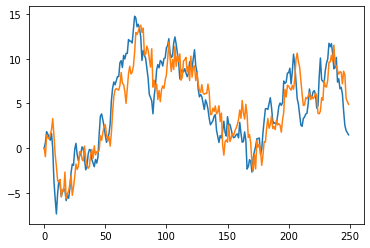

In [69]:
gamma=(0,0.3)
T=250
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()

#### VECM Estimation

In [70]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [71]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1     0.682422
del_x1    2.991730
del_x2   -2.496795
const     0.023238
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.035493
del_x1    0.074751
del_x2    0.054861
const     0.067415
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1     0.024221
del_x1    0.223634
del_x2   -0.136976
const     0.001567
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1     8.297259
del_x1    1.435914
del_x2   -4.695864
const    -0.161697
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.033575
del_x1    0.070711
del_x2    0.051896
const     0.063771
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.278580
del_x1    0.101535
del_x2   -0.243695
const    -0.010312
dtype: float64


The VECM(1) is solved equation by equation, the ols estimates are consistent, the t-values for non zero parameters is significant (>2). 

#### VAR

In [72]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 1650.9316945882354
BIC for lag1 917.0151924496986
BIC for lag2 910.3929445349397
BIC for lag3 914.0450556062603
BIC for lag4 920.1984487089342
BIC for lag5 927.1746375273349
BIC for lag6 935.0347620828179
BIC for lag7 940.6572074167658
BIC for lag8 945.724245156629
BIC for lag9 944.087186935764

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0  0.175624     1.217390    -0.192958    -0.177586     0.114532
1  0.062836     0.367311    -0.088643     0.470838     0.234263


The true model is VECM(1) which corresponds to a VAR(2) process. Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR.

#### Var in differences

In [73]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 961.8940842925194
BIC for lag1 934.4836055816766
BIC for lag2 935.5381247046226
BIC for lag3 937.8205670684029
BIC for lag4 936.0729948709088
BIC for lag5 943.2620150988249
BIC for lag6 950.0370369341379
BIC for lag7 953.4268261745453
BIC for lag8 955.8616865182419
BIC for lag9 959.520900661267

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.004708     0.251934    -0.137535
1  0.025817     0.427016    -0.250131


The VAR in differences for cointegrated I(1) processes leads to overdifferencing, such that the endogeinity condition for OLS is violated. Thus OLS is inconsistent for this case, the ols coefficients are shown for lag=1, they are completely wrong.<br>

The VECM(1) is the most efficient method for this case.

#### Long Run Regression

In [74]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,2)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.402
Date:                Sun, 26 Apr 2020   Prob (F-statistic):              0.122
Time:                        19:47:56   Log-Likelihood:                -484.39
No. Observations:                 248   AIC:                             972.8
Df Residuals:                     246   BIC:                             979.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t            0.0742      0.048      1.550      0.1

The Long run regression results are shown in the above table. The optimal R-squared is acheived at lag=2. In this question X2 is the one which error-corrects, thus we expect X2 to be predictable by X1. The R-squared for X2 predicted by X1 is 42%, while it is 1% for X1 predicted by X2

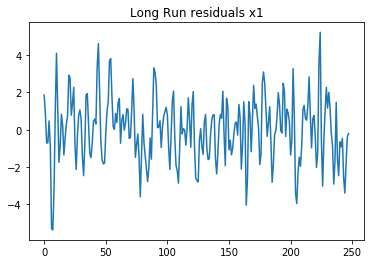

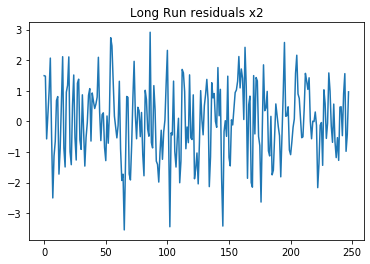

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


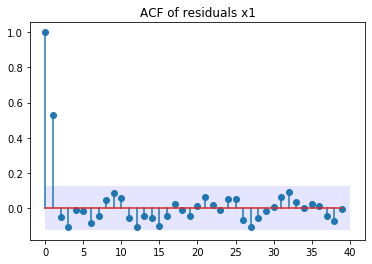

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


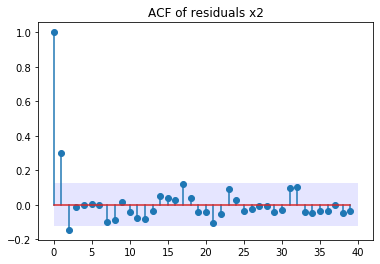

In [75]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections

In [76]:
k=2
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag=2 eqn 1  ",NW_1)

print("\n \n Newey-West lag=2 eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag=2 eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag=2 eqn 2 ",HH_2)


Newey-West lag=2 eqn 1   [[ 0.02007147 -0.00183047]
 [-0.00183047  0.00311363]]

 
 Newey-West lag=2 eqn 2  [[0.00741194 0.00023893]
 [0.00023893 0.00136163]]

 
 Hansen-Hodrick lag=2 eqn 1  [[ 0.02353961 -0.00231627]
 [-0.00231627  0.00296625]]

 
 Hansen-Hodrick lag=2 eqn 2  [[0.00732533 0.0006555 ]
 [0.0006555  0.00122407]]


## gamma= (0,0.3)'  T=2500

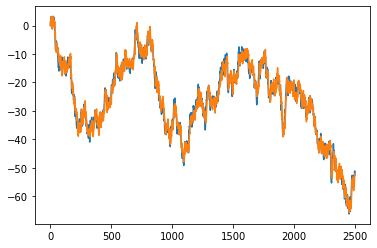

In [77]:
gamma=(0,0.3)
T=2500
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()

#### VECM

In [78]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [79]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)


OLS t-stats for eqn 1 in Vecm
Z_t-1    -0.037626
del_x1    8.671216
del_x2   -6.220382
const    -0.995447
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.011200
del_x1    0.023354
del_x2    0.015956
const     0.019699
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1    -0.000421
del_x1    0.202509
del_x2   -0.099251
const    -0.019610
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1     28.731893
del_x1    -1.169745
del_x2   -14.997201
const     -1.109404
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.011359
del_x1    0.023685
del_x2    0.016182
const     0.019978
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.326368
del_x1   -0.027705
del_x2   -0.242681
const    -0.022164
dtype: float64


The VECM(1) standard errors are smaller for T=2500 as compared to T=250, and consequently t-values are more significant.
The ols estimates remain consistent and efficient.

#### VAR

In [80]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)

BIC for lag0 21843.324744020116
BIC for lag1 8961.542298079401
BIC for lag2 8808.812010355443
BIC for lag3 8820.070371498245
BIC for lag4 8830.645432784044
BIC for lag5 8842.805681751097
BIC for lag6 8854.028694429078
BIC for lag7 8865.628701468284
BIC for lag8 8874.858933554859
BIC for lag9 8884.993682284112

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0 -0.098291     1.200259    -0.202658    -0.098391     0.097752
1  0.023353     0.299720     0.027791     0.430698     0.243548


The optimal lag for VAR remains 2, which is the same as taht for T=250

#### Var in differences

In [81]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)    

BIC for lag0 9449.063651664497
BIC for lag1 9183.544511908407
BIC for lag2 9107.287908291943
BIC for lag3 9045.992072782112
BIC for lag4 9025.629531632681
BIC for lag5 9012.9904323903
BIC for lag6 8995.722195793653
BIC for lag7 8982.854638786645
BIC for lag8 8981.808983105504
BIC for lag9 8982.171383249788

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.019612     0.202029    -0.099212
1 -0.019889     0.343967    -0.272947


The Var in differences in this case also is inconsistent and mis-specified.

## Long run Regression

In [82]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,4)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8160
Date:                Sun, 26 Apr 2020   Prob (F-statistic):              0.366
Time:                        19:48:01   Log-Likelihood:                -5601.4
No. Observations:                2496   AIC:                         1.121e+04
Df Residuals:                    2494   BIC:                         1.122e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t           -0.0197      0.022     -0.903      0.3

The optimal lag according to R-squared is found at lag=4. The OLS coefficients remain consistent but we need to use Newey west standard errors.

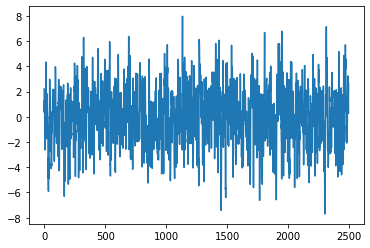

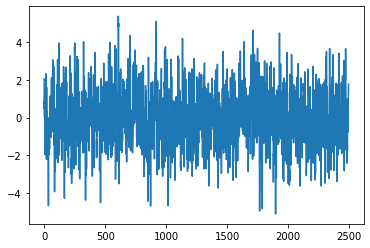

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


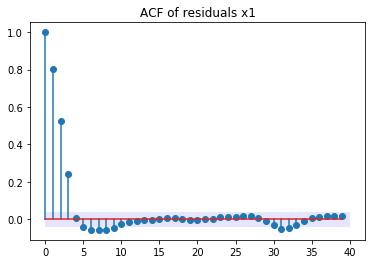

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


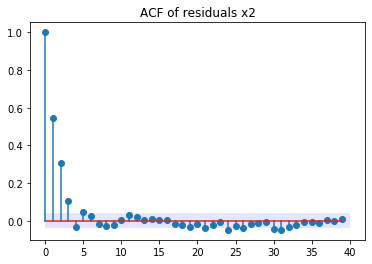

In [83]:
plt.plot(e_x1)
plt.show()
plt.plot(e_x2)
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

As usual ACF of residuals imply that serial correlation is present.

In [84]:
k=4
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag=4 eqn 1  ",NW_1)

print("\n \n Newey-West lag=4 eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag=4 eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag=4 eqn 2 ",HH_2)


Newey-West lag=4 eqn 1   [[6.48696559e-03 3.52605651e-06]
 [3.52605651e-06 1.03015456e-03]]

 
 Newey-West lag=4 eqn 2  [[ 2.07684609e-03 -6.06180950e-06]
 [-6.06180950e-06  3.78817976e-04]]

 
 Hansen-Hodrick lag=4 eqn 1  [[8.65564229e-03 3.11233054e-05]
 [3.11233054e-05 1.22268714e-03]]

 
 Hansen-Hodrick lag=4 eqn 2  [[ 2.55546684e-03 -4.16582137e-05]
 [-4.16582137e-05  4.56300539e-04]]


## gamma= (0,0.03)'  T=250

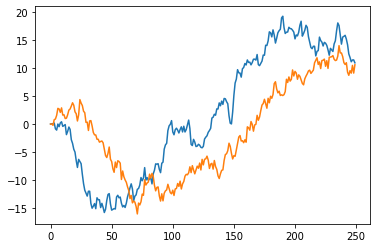

In [85]:
gamma=(0,0.03)
T=250
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()

In [86]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [87]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1     1.542872
del_x1    2.215288
del_x2   -1.940914
const    -0.045835
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.008882
del_x1    0.064699
del_x2    0.065921
const     0.069401
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1     0.013704
del_x1    0.143326
del_x2   -0.127947
const    -0.003181
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1     4.374092
del_x1    0.089845
del_x2   -3.671644
const    -1.060204
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.008274
del_x1    0.060268
del_x2    0.061407
const     0.064649
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.036191
del_x1    0.005415
del_x2   -0.225464
const    -0.068541
dtype: float64


The VECM(1) is solved equation by equation, the ols estimates are consistent, the t-values for non zero parameters is significant . 

#### VAR

In [88]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Results for lag 1")
result_Var=Var(x1,x2,1)
print("\n OLS Coefficients")

print(result_Var.params.T)

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 2021.6822537842413
BIC for lag1 879.3001136697809
BIC for lag2 878.3360900341997
BIC for lag3 883.3538952985475
BIC for lag4 889.7051617988293
BIC for lag5 896.3635312053176
BIC for lag6 899.6123280093143
BIC for lag7 904.8155673959343
BIC for lag8 911.6770285537913
BIC for lag9 919.1301169628299

 Results for lag 1

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.033762     1.016195    -0.034957
1 -0.067731     0.032454     0.964611

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0 -0.024508     1.138535    -0.124431    -0.144460     0.114867
1 -0.069257     0.040984    -0.004780     0.738251     0.225025


The true model is VECM(1) which corresponds to a VAR(2) process. Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR. 

#### Var in differences

In [89]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 880.6191215609263
BIC for lag1 879.5348720829686
BIC for lag2 883.0403114225397
BIC for lag3 890.2866788116536
BIC for lag4 897.9679059018463
BIC for lag5 904.5476183848336
BIC for lag6 910.3835308889606
BIC for lag7 917.1295145598983
BIC for lag8 922.5711617819178
BIC for lag9 930.0126250251907

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.040485     0.166220    -0.116925
1  0.046777     0.065876    -0.196357


The VAR in differences for cointegrated I(1) processes leads to overdifferencing, such that the endogeinity condition for OLS is violated. Thus OLS is inconsistent for this case, the ols coefficients are shown for lag=1<br>

**However, since the cointegration is small we can see that now the ols estimates are much closer to the true values of $\Psi_1$**

The VECM(1) is the most efficient method for this case.

#### Long Run Regression

In [90]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,20)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     17.92
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           3.35e-05
Time:                        19:49:01   Log-Likelihood:                -709.79
No. Observations:                 230   AIC:                             1424.
Df Residuals:                     228   BIC:                             1430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t            0.1939      0.046      4.233      0.0

The Long run regression results are shown in the above table. **Higher lags are required as compared to $\gamma_1$ to have significant R-squared and make meaningful predictions. This implies that low correlation leads to predictability only on the long run**

**More over since the cointegration is small and sample size is also small, these results are not very repeatable**

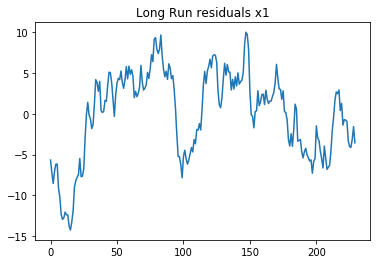

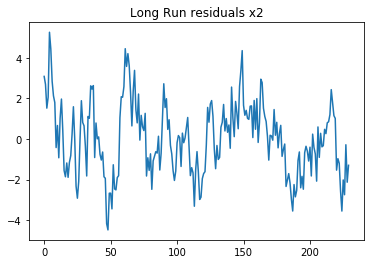

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


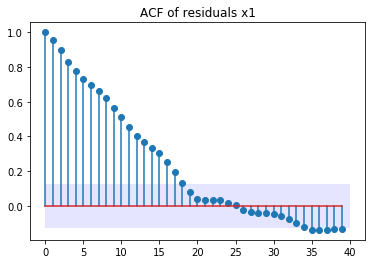

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


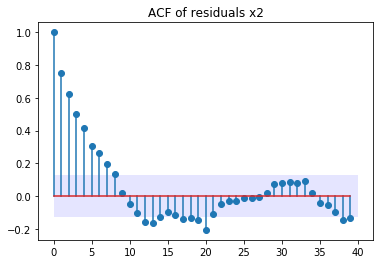

In [91]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections

In [92]:
k=20
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag",k," eqn 1  ",NW_1)

print("\n \n Newey-West lag",k," eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag",k," eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag",k," eqn 2 ",HH_2)


Newey-West lag 20  eqn 1   [[ 2.33199251 -0.13493565]
 [-0.13493565  0.01977995]]

 
 Newey-West lag 20  eqn 2  [[ 0.07037601 -0.00089163]
 [-0.00089163  0.00099239]]

 
 Hansen-Hodrick lag 20  eqn 1  [[ 3.53588146 -0.20924994]
 [-0.20924994  0.02899662]]

 
 Hansen-Hodrick lag 20  eqn 2  [[-0.00456147  0.00910436]
 [ 0.00910436  0.00044357]]


## gamma= (0,0.03)'  T=2500

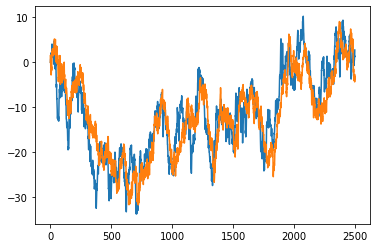

In [93]:
gamma=(0,0.03)
T=2500
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()

In [94]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [95]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1    -1.352242
del_x1    8.928751
del_x2   -5.464586
const     0.101684
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.004042
del_x1    0.020055
del_x2    0.018985
const     0.019814
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1    -0.005466
del_x1    0.179065
del_x2   -0.103743
const     0.002015
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1      9.792248
del_x1     1.872059
del_x2   -12.298592
const     -0.614014
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.004064
del_x1    0.020162
del_x2    0.019086
const     0.019920
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.039795
del_x1    0.037745
del_x2   -0.234737
const    -0.012231
dtype: float64


The VECM(1) is solved equation by equation, the ols estimates are consistent, the t-values for non zero parameters is significant and higher in magnitude than at T=250. 

#### VAR

In [96]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Results for lag 1")
result_Var=Var(x1,x2,1)
print("\n OLS Coefficients")

print(result_Var.params.T)

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 19873.10810653896
BIC for lag1 8922.252543867662
BIC for lag2 8810.158756588671
BIC for lag3 8822.688646651028
BIC for lag4 8832.192789083587
BIC for lag5 8844.238430010506
BIC for lag6 8855.996835731365
BIC for lag7 8866.542613712334
BIC for lag8 8878.938231314642
BIC for lag9 8890.329389628734

 Results for lag 1

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.080468     0.999533    -0.006462
1 -0.047941     0.040356     0.956536

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0 -0.066619     1.170615    -0.177863    -0.099454     0.100844
1 -0.029707     0.076781    -0.037439     0.725168     0.233998


The true model is VECM(1) which corresponds to a VAR(2) process. Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR. 

#### Var in differences

In [97]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 8962.97419576128
BIC for lag1 8846.723168808885
BIC for lag2 8858.88752083644
BIC for lag3 8865.92070891728
BIC for lag4 8877.451698707308
BIC for lag5 8888.322260267501
BIC for lag6 8895.655555734613
BIC for lag7 8906.071441858705
BIC for lag8 8916.326630327856
BIC for lag9 8927.07874030283

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.000634     0.173690    -0.103434
1 -0.002182     0.076876    -0.236987


The VAR in differences for cointegrated I(1) processes leads to overdifferencing, such that the endogeinity condition for OLS is violated. Thus OLS is inconsistent for this case, the ols coefficients are shown for lag=1.<br>

**However, since co-integration is small in this case, using VAR in differencing would not be disastrous, the optimal lag length is 2, the ols coefficients estimated seem close enough to the true values**

The VECM(1) is the most efficient method for this case.

#### Long Run Regression

In [98]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,10)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     24.42
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           8.25e-07
Time:                        19:49:24   Log-Likelihood:                -6663.7
No. Observations:                2490   AIC:                         1.333e+04
Df Residuals:                    2488   BIC:                         1.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t           -0.0697      0.014     -4.942      0.0

The Long run regression results are shown in the above table. In this question X2 is the one which error-corrects, thus we expect X2 to be predictable by X1. The optimal R-squared is acheived at lag=95, but because we need to invert X'X matrix for Var-covariance matrix, which is computationally expensive, we chose a smaller number of lags. 

**As compared to $\gamma_1$ the required lags in long run regression for predictability is much higher, ie. if co-integration is low, the prediction can be made on the long run, not for small timeframes.**

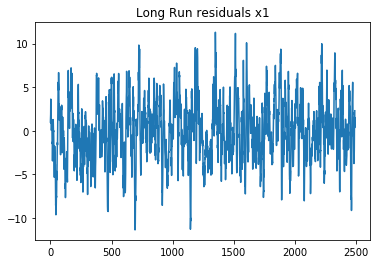

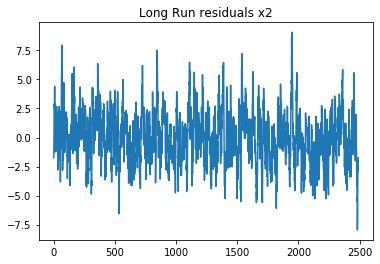

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


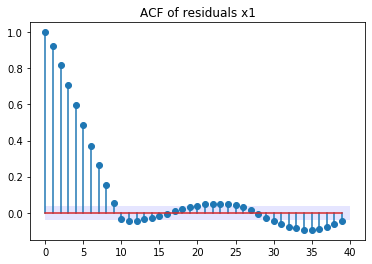

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


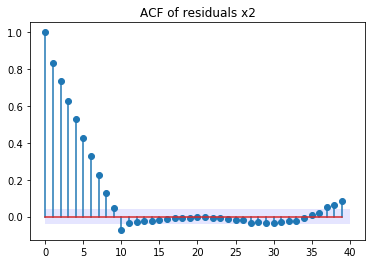

In [99]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections.


In [100]:
k=10
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag",k," eqn 1  ",NW_1)

print("\n \n Newey-West lag",k," eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag",k," eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag",k," eqn 2 ",HH_2)


Newey-West lag 10  eqn 1   [[ 0.03492672 -0.00078882]
 [-0.00078882  0.00110422]]

 
 Newey-West lag 10  eqn 2  [[ 0.01319145 -0.00012492]
 [-0.00012492  0.00045269]]

 
 Hansen-Hodrick lag 10  eqn 1  [[ 0.04857145 -0.00103856]
 [-0.00103856  0.0013489 ]]

 
 Hansen-Hodrick lag 10  eqn 2  [[ 0.01803137 -0.00014721]
 [-0.00014721  0.00059215]]


## gamma= (-0.25,0.1)'  T=250

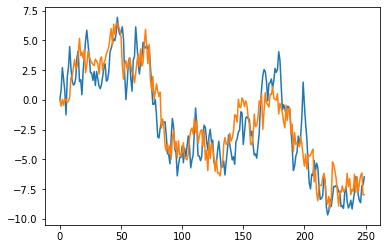

In [101]:
gamma=(-0.25,0.1)
T=250
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()

In [102]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [103]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1    -8.086836
del_x1    5.442568
del_x2   -2.389493
const    -1.409806
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.039269
del_x1    0.058356
del_x2    0.065085
const     0.064350
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1    -0.317561
del_x1    0.317607
del_x2   -0.155519
const    -0.090722
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1     2.060509
del_x1    0.622397
del_x2   -4.579510
const    -0.351415
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.038379
del_x1    0.057034
del_x2    0.063610
const     0.062892
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.079080
del_x1    0.035498
del_x2   -0.291301
const    -0.022101
dtype: float64


The VECM(1) is solved equation by equation, the ols estimates are consistent, the t-values for non zero parameters is significant . 

#### VAR

In [104]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Results for lag 1")
result_Var=Var(x1,x2,1)
print("\n OLS Coefficients")

print(result_Var.params.T)

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 1594.103633108784
BIC for lag1 913.0024373672891
BIC for lag2 895.1179638672367
BIC for lag3 900.7697249185202
BIC for lag4 902.7783161665368
BIC for lag5 910.1263085538046
BIC for lag6 913.2972973971154
BIC for lag7 914.3696804688068
BIC for lag8 921.7911483429591
BIC for lag9 925.3185354203591

 Results for lag 1

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.073851     0.769554     0.230056
1 -0.042912     0.138956     0.836615

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0 -0.091767     1.000074    -0.317711     0.161797     0.155195
1 -0.047669     0.115255    -0.038030     0.623647     0.283364


The true model is VECM(1) which corresponds to a VAR(2) process. Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR.

#### Var in differences

In [105]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 929.3409258986107
BIC for lag1 918.2885402959448
BIC for lag2 920.6946793549655
BIC for lag3 909.4158539742848
BIC for lag4 916.4911964935886
BIC for lag5 915.2468831020109
BIC for lag6 916.6907601823565
BIC for lag7 922.9667064103804
BIC for lag8 925.2901326173629
BIC for lag9 929.967543597025

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.023302     0.181556     0.030729
1 -0.038890     0.069378    -0.337682


The VAR in differences for cointegrated I(1) processes leads to overdifferencing, such that the endogeinity condition for OLS is violated. Thus OLS is inconsistent for this case, the ols coefficients are shown for lag=1, they are completely wrong.<br>

The VECM(1) is the most efficient method for this case.

#### Long Run Regression

In [106]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,4)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     151.7
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           1.97e-27
Time:                        19:51:29   Log-Likelihood:                -492.82
No. Observations:                 246   AIC:                             989.6
Df Residuals:                     244   BIC:                             996.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t           -0.7826      0.064    -12.317      0.0

 **The Long run regression results are shown in the above table. The optimal R-squared is acheived at lag=4. In this question part, both x1 and x2 error correct, Thus both are relatively better predictable by each other than in previous cases**

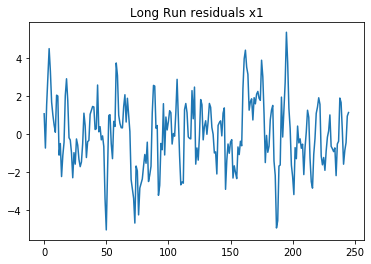

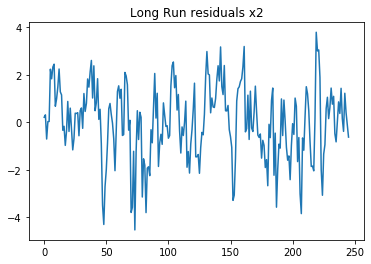

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


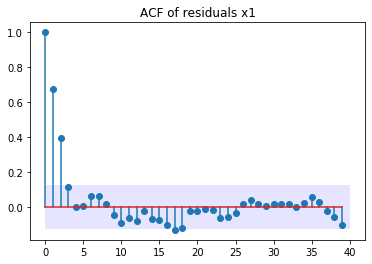

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


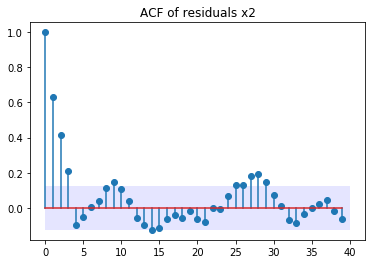

In [107]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections

In [108]:
k=4
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag",k," eqn 1  ",NW_1)

print("\n \n Newey-West lag",k," eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag",k," eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag",k," eqn 2 ",HH_2)


Newey-West lag 4  eqn 1   [[0.03486511 0.00156477]
 [0.00156477 0.00620418]]

 
 Newey-West lag 4  eqn 2  [[ 0.02462761 -0.00109818]
 [-0.00109818  0.00545008]]

 
 Hansen-Hodrick lag 4  eqn 1  [[0.04410063 0.00173089]
 [0.00173089 0.00700941]]

 
 Hansen-Hodrick lag 4  eqn 2  [[ 0.03069187 -0.00226511]
 [-0.00226511  0.00644151]]


## gamma= (-0.25,0.1)'  T=2500

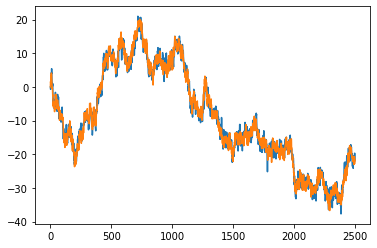

In [109]:
gamma=(-0.25,0.1)
T=2500
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()


In [110]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [111]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1    -20.874354
del_x1    10.848313
del_x2    -4.417750
const     -1.050666
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.011786
del_x1    0.019124
del_x2    0.019907
const     0.019870
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1    -0.246019
del_x1    0.207464
del_x2   -0.087942
const    -0.020876
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1      8.873956
del_x1     1.029586
del_x2   -11.454272
const     -0.277811
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.011820
del_x1    0.019180
del_x2    0.019965
const     0.019927
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.104891
del_x1    0.019747
del_x2   -0.228680
const    -0.005536
dtype: float64


The VECM(1) is solved equation by equation, the ols estimates are consistent, the t-values for non zero parameters is significant  
**Standard errors are smaller compared to T=250**

#### VAR

In [112]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Results for lag 1")
result_Var=Var(x1,x2,1)
print("\n OLS Coefficients")

print(result_Var.params.T)

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 22091.159309890914
BIC for lag1 8940.830202791405
BIC for lag2 8822.58504878829
BIC for lag3 8834.26150931301
BIC for lag4 8845.16156564537
BIC for lag5 8857.331332807986
BIC for lag6 8864.97386479239
BIC for lag7 8875.527417588306
BIC for lag8 8884.641965026329
BIC for lag9 8892.4220975618

 Results for lag 1

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.043853     0.801058     0.196329
1 -0.003561     0.151080     0.848600

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0 -0.050803     0.959821    -0.209088     0.157956     0.088122
1 -0.009656     0.124414    -0.019971     0.666413     0.228704


The true model is VECM(1) which corresponds to a VAR(2) process. Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR.

#### Var in differences

In [113]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 9169.6750470069
BIC for lag1 9054.296775003153
BIC for lag2 9031.92883093518
BIC for lag3 9000.778651093062
BIC for lag4 8991.498067706103
BIC for lag5 8970.899182133353
BIC for lag6 8969.31093452465
BIC for lag7 8972.946593710614
BIC for lag8 8970.130906112941
BIC for lag9 8981.325673533274

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0 -0.007320     0.098826     0.050223
1 -0.011316     0.066065    -0.287587


The VAR in differences for cointegrated I(1) processes leads to overdifferencing, such that the endogeinity condition for OLS is violated. Thus OLS is inconsistent for this case, the ols coefficients are shown for lag=1, they are completely wrong.<br>

The VECM(1) is the most efficient method for this case.

#### Long Run Regression

In [114]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,4)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     1111.
Date:                Sun, 26 Apr 2020   Prob (F-statistic):          8.93e-202
Time:                        19:51:37   Log-Likelihood:                -4959.9
No. Observations:                2496   AIC:                             9924.
Df Residuals:                    2494   BIC:                             9935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t           -0.6348      0.019    -33.329      0.0

The Long run regression results are shown in the above table.
**The predictability is higher than T=250 because of the larger sample size**

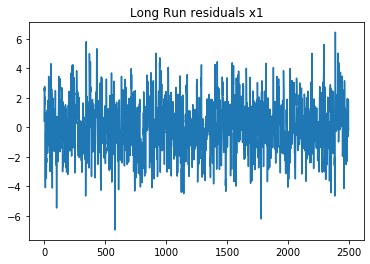

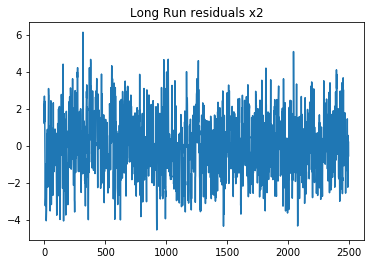

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


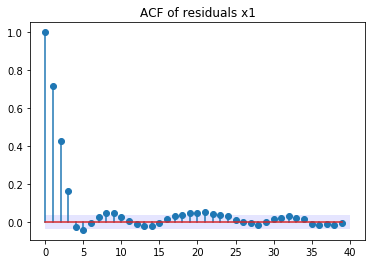

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


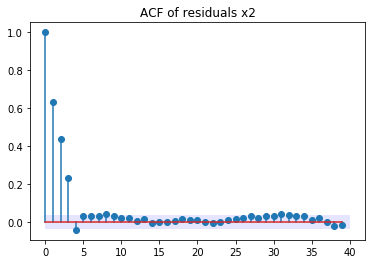

In [115]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections

In [116]:
k=4
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag",k," eqn 1  ",NW_1)

print("\n \n Newey-West lag",k," eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag",k," eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag",k," eqn 2 ",HH_2)


Newey-West lag 4  eqn 1   [[3.46391876e-03 5.09873593e-05]
 [5.09873593e-05 6.31801116e-04]]

 
 Newey-West lag 4  eqn 2  [[ 2.71391215e-03 -1.75079991e-05]
 [-1.75079991e-05  5.62868169e-04]]

 
 Hansen-Hodrick lag 4  eqn 1  [[4.43624279e-03 5.79477187e-05]
 [5.79477187e-05 7.16057818e-04]]

 
 Hansen-Hodrick lag 4  eqn 2  [[ 3.52584001e-03 -6.34147080e-05]
 [-6.34147080e-05  6.60367472e-04]]


## gamma= (-0,0)'  T=250

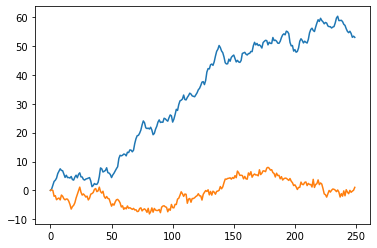

In [117]:
gamma=(0,0)
T=250
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()


In [118]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [119]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1    -1.312039
del_x1    4.498236
del_x2   -1.849740
const     2.287259
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.003519
del_x1    0.061173
del_x2    0.062154
const     0.134974
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1    -0.004618
del_x1    0.275169
del_x2   -0.114968
const     0.308721
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1     0.974238
del_x1    0.708810
del_x2   -4.970305
const    -0.902625
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.003461
del_x1    0.060155
del_x2    0.061120
const     0.132729
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.003372
del_x1    0.042638
del_x2   -0.303784
const    -0.119804
dtype: float64


The VECM(1) is solved equation by equation
**since there is no-cointegration in this case, the VECM is mis-specified**

#### VAR

In [120]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Results for lag 1")
result_Var=Var(x1,x2,1)
print("\n OLS Coefficients")

print(result_Var.params.T)

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 2218.7213764373423
BIC for lag1 888.2421086053564
BIC for lag2 875.1475350192248
BIC for lag3 881.3245736001721
BIC for lag4 885.1874261235533
BIC for lag5 892.8950630302896
BIC for lag6 895.3306412088294
BIC for lag7 898.859260761173
BIC for lag8 906.3159508829955
BIC for lag9 910.7640635752381

 Results for lag 1

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.336336     0.996115    -0.007759
1 -0.309276     0.008427     0.945082

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0  0.294390     1.270188    -0.274437    -0.112269     0.113312
1 -0.279299     0.041960    -0.034494     0.671491     0.285347


 Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR. Looking at VAR(1), the sum of the rows of the $\Psi$ matrix is close to 1, which is what was expected
 **VAR is consistent but not the most efficient**

#### Var in differences

In [121]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 882.3727505828255
BIC for lag1 867.6872337184716
BIC for lag2 874.0632170206442
BIC for lag3 877.7714051780356
BIC for lag4 885.6941510555603
BIC for lag5 886.9161213094285
BIC for lag6 890.5957079000775
BIC for lag7 897.7997798155827
BIC for lag8 902.5623258472708
BIC for lag9 907.2463180829219

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.151873     0.277948    -0.115050
1 -0.005276     0.040609    -0.303724


**Var in differences in this case is consistent and efficient**

#### Long Run Regression

In [122]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,5)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     6.971
Date:                Sun, 26 Apr 2020   Prob (F-statistic):            0.00882
Time:                        19:52:33   Log-Likelihood:                -586.24
No. Observations:                 245   AIC:                             1176.
Df Residuals:                     243   BIC:                             1183.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t           -0.0257      0.010     -2.640      0.0

The Long run regression results are shown in the above table.
**The R-squared is significant, but this is due to small sample size. We will see if there is any predictability for large samples**

**The cointegration is 0, thus we expect r-squared to be 0 for large sample sizes**

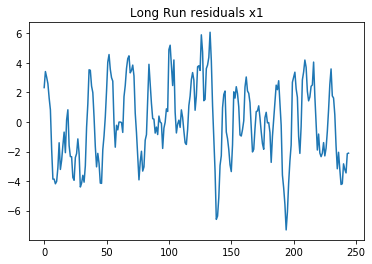

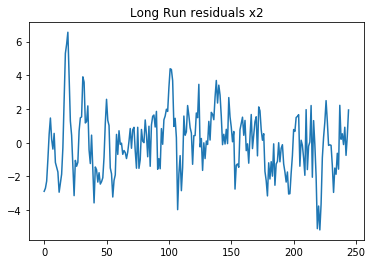

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


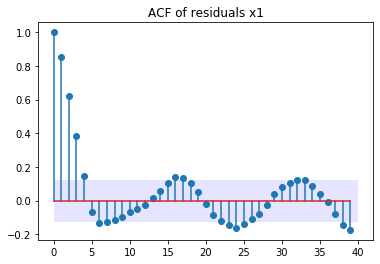

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


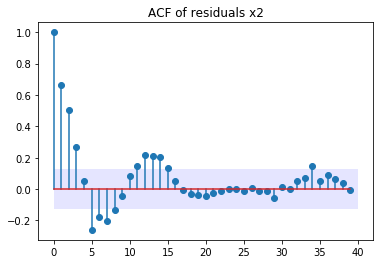

In [123]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections

In [124]:
k=5
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag",k," eqn 1  ",NW_1)

print("\n \n Newey-West lag",k," eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag",k," eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag",k," eqn 2 ",HH_2)


Newey-West lag 5  eqn 1   [[ 5.37217505e-01 -1.29320576e-02]
 [-1.29320576e-02  3.87590010e-04]]

 
 Newey-West lag 5  eqn 2  [[ 2.49875569e-01 -5.88586018e-03]
 [-5.88586018e-03  1.65383953e-04]]

 
 Hansen-Hodrick lag 5  eqn 1  [[ 7.26391188e-01 -1.74097948e-02]
 [-1.74097948e-02  5.15566822e-04]]

 
 Hansen-Hodrick lag 5  eqn 2  [[ 2.58417333e-01 -6.12891330e-03]
 [-6.12891330e-03  1.77968833e-04]]


## gamma= (-0,0)'  T=2500

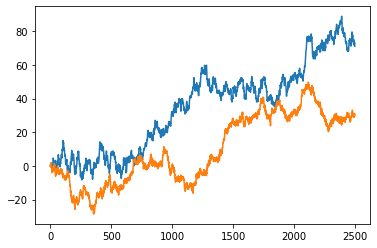

In [125]:
gamma=(0,0)
T=2500
[x1,x2]=simulate_process(gamma, T)
plt.plot(x1)
plt.plot(x2)
plt.show()


In [126]:
[results_x1,results_x2]=solve_Vecm1(x1,x2)

In [127]:
print("OLS t-stats for eqn 1 in Vecm")
print(results_x1.tvalues)
print("\n OLS standard errors for eqn 1 in Vecm")
print(results_x1.bse)
print("\n OLS coeffcients for eqn 1 in Vecm")
print(results_x1.params)
print("\n OLS t-stats for eqn 2 in Vecm")
print(results_x2.tvalues)
print("\n OLS standard errors for eqn 2 in Vecm")
print(results_x2.bse)
print("\n OLS coeffcients for eqn 2 in Vecm")
print(results_x2.params)

OLS t-stats for eqn 1 in Vecm
Z_t-1    -2.232324
del_x1    8.801170
del_x2   -4.361858
const     2.512658
dtype: float64

 OLS standard errors for eqn 1 in Vecm
Z_t-1     0.001262
del_x1    0.019646
del_x2    0.019935
const     0.037585
dtype: float64

 OLS coeffcients for eqn 1 in Vecm
Z_t-1    -0.002817
del_x1    0.172906
del_x2   -0.086952
const     0.094439
dtype: float64

 OLS t-stats for eqn 2 in Vecm
Z_t-1      1.163892
del_x1     0.303425
del_x2   -12.679540
const     -0.576999
dtype: float64

 OLS standard errors for eqn 2 in Vecm
Z_t-1     0.001229
del_x1    0.019129
del_x2    0.019410
const     0.036596
dtype: float64

 OLS coeffcients for eqn 2 in Vecm
Z_t-1     0.001430
del_x1    0.005804
del_x2   -0.246108
const    -0.021116
dtype: float64


The VECM(1) is solved equation by equation
**since there is no-cointegration in this case, the VECM is mis-specified**

#### VAR

In [128]:
#VAR
for i in range(0,10):
    print("BIC for lag"+str(i),Var(x1,x2,i).bic)
    
print("\n Results for lag 1")
result_Var=Var(x1,x2,1)
print("\n OLS Coefficients")

print(result_Var.params.T)

print("\n Optimal lag length according to BIC is 2")
result_Var=Var(x1,x2,2)
print("\n OLS Coefficients")

print(result_Var.params.T)


BIC for lag0 24575.930058932634
BIC for lag1 9041.2496943235
BIC for lag2 8929.7319327873
BIC for lag3 8939.399845136872
BIC for lag4 8949.028351677392
BIC for lag5 8958.011490577868
BIC for lag6 8967.31422711246
BIC for lag7 8976.220842198529
BIC for lag8 8988.204171400146
BIC for lag9 8996.36884083532

 Results for lag 1

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.084929     0.997633     0.002624
1 -0.024563     0.001915     0.996935

 Optimal lag length according to BIC is 2

 OLS Coefficients
          0  x1_lags p=2  x1_lags p=1  x2_lags p=2  x2_lags p=1
0  0.091123     1.170053    -0.172869    -0.083987     0.087141
1 -0.013393     0.007318    -0.005889     0.752116     0.245668


 Using the BIC criterion to select VAR(p) also yeilds the same result. Optimal lag length is 2 for VAR. Looking at VAR(1), the sum of the rows of the $\Psi$ matrix is close to 1, which is what was expected
 **VAR is consistent but not the most efficient**

#### Var in differences

In [129]:
delta_x1=  np.zeros((1,len(x1)-1))
delta_x2=  np.zeros((1,len(x2)-1))

for i in range(1,len(x1)):
    delta_x1[0][i-1]=x1[i]-x1[i-1]
    delta_x2[0][i-1]=x2[i]-x2[i-1]
    
for i in range(0,10):
    print("BIC for lag"+str(i),Var(delta_x1[0],delta_x2[0],i).bic)
    
result_Vardelta=Var(delta_x1[0],delta_x2[0],1)
print("\n OLS Coefficients")

print(result_Vardelta.params.T)   
 


BIC for lag0 9029.118392732253
BIC for lag1 8917.671058155505
BIC for lag2 8927.17916690064
BIC for lag3 8936.670941026681
BIC for lag4 8945.606685513421
BIC for lag5 8954.991779275764
BIC for lag6 8963.751288057676
BIC for lag7 8975.633995117048
BIC for lag8 8983.671133454925
BIC for lag9 8994.452322759187

 OLS Coefficients
          0  x1_lags p=1  x2_lags p=1
0  0.024242     0.171708     -0.08551
1  0.014520     0.006412     -0.24684


**Var in differences in this case is consistent and efficient, optimal lags=1**

#### Long Run Regression

In [130]:
results1, results2, e_x1,e_x2=longrun_regress(x1,x2,5)
print(results1.summary())
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     x1   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     22.32
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           2.43e-06
Time:                        19:52:41   Log-Likelihood:                -5941.2
No. Observations:                2495   AIC:                         1.189e+04
Df Residuals:                    2493   BIC:                         1.190e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z_t           -0.0152      0.003     -4.725      0.0

The Long run regression results are shown in the above table.
**The R-squared is essentially 0. There is no predictability**

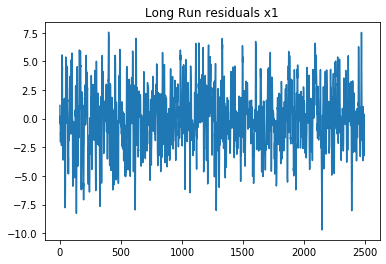

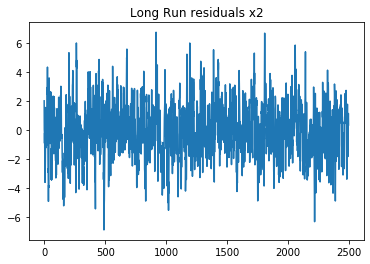

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


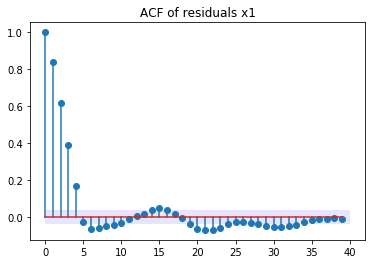

C:\Users\UniversityGrass\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


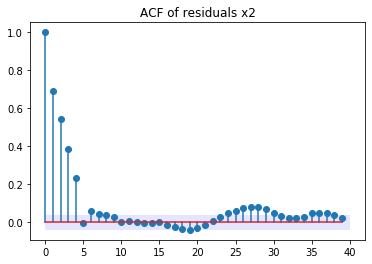

In [131]:
plt.plot(e_x1)
plt.title("Long Run residuals x1")
plt.show()
plt.plot(e_x2)
plt.title("Long Run residuals x2")
plt.show()


plot_ACF(e_x1, 40)
plt.title("ACF of residuals x1")
plt.show()

plot_ACF(e_x2, 40)
plt.title("ACF of residuals x2")
plt.show()

From the ACF of the residuals of the long run regression, it is clear that serial correlation is present, thus we need to use
Newey-West or Hansen-Hodrick corrections

In [132]:
k=5
z=x1-x2
ones=np.ones((len(z)-k,1))
X=pd.DataFrame(ones)
X.columns=["const"]
X["Z_t"]=pd.DataFrame(z[:-k])

NW_1= Newey_West(X,e_x1.values,k)
NW_2= Newey_West(X,e_x2.values,k)

HH_1=Hansen_Hodrick(X,e_x1.values,k)
HH_2=Hansen_Hodrick(X,e_x2.values,k)

print("Newey-West lag",k," eqn 1  ",NW_1)

print("\n \n Newey-West lag",k," eqn 2 ",NW_2)

print("\n \n Hansen-Hodrick lag",k," eqn 1 ",HH_1)

print("\n \n Hansen-Hodrick lag",k," eqn 2 ",HH_2)


Newey-West lag 5  eqn 1   [[ 3.35443225e-02 -9.39922539e-04]
 [-9.39922539e-04  3.78626531e-05]]

 
 Newey-West lag 5  eqn 2  [[ 1.57869136e-02 -4.23951841e-04]
 [-4.23951841e-04  1.60832294e-05]]

 
 Hansen-Hodrick lag 5  eqn 1  [[ 4.39616323e-02 -1.21949661e-03]
 [-1.21949661e-03  4.90981618e-05]]

 
 Hansen-Hodrick lag 5  eqn 2  [[ 2.19087055e-02 -5.68156955e-04]
 [-5.68156955e-04  2.06091588e-05]]
